In [6]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
from torch.nn.parameter import Parameter
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator # for minor ticks
from matplotlib import gridspec
from matplotlib import patches
from matplotlib.offsetbox import TextArea, VPacker, AnnotationBbox

import numpy as np

import scipy.stats as scstats
import scipy.special as sps

import pickle

import sys
sys.path.append("..")


import neuroprob as mdl
import neuroprob.utils as utils

dev = utils.pytorch.get_device(gpu=0)

plt.style.use(['paper.mplstyle'])

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
PyTorch version: 1.7.1+cu101
Using device: cuda:0


##### Description
This notebook contains code for:
- Compare LVM, LVM + self-coupling, full GLM coupling to explain correlations
- Neural data is synthetic Gaussian place field population with low dimensional correlations and real place field data

### Neural data

In [ ]:
# Synthetic data
sample_bin, track_samples, x_t, y_t, s_t, hd_t, theta_t, dir_t, \
    syn_t_spike, spike_samples, units, \
    left_x, right_x, bottom_y, top_y = pickle.load(open('../data/synthetic/gauss_pop_cond.p', 'rb'))

max_speed = s_t.max()
wrap_theta_t = tools.WrapPi(theta_t, True)

arena_width = (right_x - left_x)
arena_height = (top_y - bottom_y)
behav_list = [x_t, y_t]

bin_size = 1
T = 50000
tbin, resamples, rc_t, rbehav_t = neural_utils.BinTrain(bin_size, sample_bin, [s[s < T] for s in syn_t_spike], T, 
                                                        tuple(behav_list), average_behav=False)

In [1]:
# Real data

In [ ]:
len(syn_t_spike[0])

### Model comparison

In [28]:
# full GP-GLM
units_ = units#1
l = 1.*np.ones(units_)
v = 1.*np.ones(units_)
kernels_tuples = [('RBF', 'euclid', np.array([l, l]), v)]
prior_tuple = [(None,), (None,)]#[('Normal', 'euclid', 0.0, 1.0, False, False), ('Normal', 'euclid', 0.0, 1.0, False, False)]
#prior_tuple = [('GP', gp_base_1), ('GP', gp_base_2)]
#prior_tuple = [('RW', 'euclid', 0.0, 1.0, True, True), ('RW', 'euclid', 0.0, 1.0, True, True)]
variational_types = [(None,), (None,)]#[('Normal', 'euclid'), ('Normal', 'euclid')]

num_induc = 16
inducing_points = np.array([left_x + arena_width*np.random.rand(num_induc), \
                            bottom_y + arena_height*np.random.rand(num_induc)]).T[None, ...].repeat(units, axis=0)

glm_rate = mdl.nonparametrics.GP_covariates(units, inducing_points, kernels_tuples, 
                                          prior_tuple, variational_types,
                                          shared_kernel_params=False, full_cov_fit=False)
glm_rate.set_params(tbin, jitter=1e-4)

likelihood = mdl.likelihoods.Poisson(units, 'exp')
likelihood.set_params(tbin)


    
# NLL model
gp = False
if gp:
    hist_len = 99 # 100 steps of spiketrain, no instantaneous element
    hist_couple = mdl.filters.GP_filter(units, units, hist_len, tbin, conv_groups=1, tens_type=torch.float)
else:
    w_h = np.zeros((2, 5, 5))
    phi_h = np.ones((2, 5, 5))

    hist_len = 99 # 100 steps of spiketrain, no instantaneous element
    hist_couple = mdl.filters.raised_cosine_bumps(a=1., c=1., phi=phi_h, w=w_h, timesteps=hist_len)

glm = mdl.inference.nll_optimized([glm_rate], likelihood, spk_couple=hist_couple)
glm.to(dev)

In [55]:
# preprocessing
ini_X = [rbehav_t[0], rbehav_t[1]]

glm.preprocess(ini_X, resamples, rc_t, batch_size=50000)
glm.to(dev)

sch = lambda o: optim.lr_scheduler.MultiplicativeLR(o, lambda e: 0.9)
opt_tuple = (optim.Adam, 100, sch)
opt_lr_dict = {'default': 1e-2}#, 'lv_std_0': 5*1e-3, 'lv_std_1': 5*1e-3, 'kernel.lengthscale': 5*1e-3}
glm.set_optimizers(opt_tuple, opt_lr_dict)

# fit to population
annealing = lambda x: 1.0#min(1.0, 0.005*x)
losses = glm.fit(3000, margin=1e1, premature=100, anneal_func=annealing, 
                 cov_samples=1, ll_samples=10)

plt.figure()
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('NLL')
plt.show()

torch.Size([1, 5, 49901])
torch.Size([1, 5, 49901])
torch.Size([1, 5, 49901])
torch.Size([1, 5, 49901])
torch.Size([1, 5, 49901])


KeyboardInterrupt: 

In [205]:
names = list(glm.named_parameters())
print([n[0] for n in names])
print(glm.rate_model[0].u_scale_tril_unconstrained.shape)
print(glm.spk_couple.GP.u_scale_tril_unconstrained.shape)

['rate_model.0.mean', 'rate_model.0.Xu', 'rate_model.0.u_loc', 'rate_model.0.u_scale_tril', 'rate_model.0.kernel.variance', 'rate_model.0.kernel.lengthscale', 'spk_couple.GP.mean', 'spk_couple.GP.Xu', 'spk_couple.GP.u_loc', 'spk_couple.GP.u_scale_tril', 'spk_couple.GP.kernel.variance', 'spk_couple.GP.kernel.lengthscale']


ModuleAttributeError: 'GP_covariates' object has no attribute 'u_scale_tril_unconstrained'

In [202]:
def get_field(glm_rate, grid_size, grid_shape, neuron):

    def func(pos):
        prevshape = pos.shape[1:]
        x = pos[0].flatten()
        y = pos[1].flatten()
        covariates = [x, y]
        return glm_rate.eval_rate(covariates, neuron).reshape(-1, *prevshape)

    _, field = tools.compute_mesh(grid_size, grid_shape, func)
    return field


def compute_rate(glm_rate, neuron):
    grid_size = [50, 40]
    grid_shape = [[left_x, right_x], [bottom_y, top_y]]
    field = get_field(glm_rate, grid_size, grid_shape, neuron)
    return field

def compute_stats(glm_rate, t_spike): # statistics
    bs = 5000
    T = 100000
    N = int(np.ceil(T/bs))
    rate_model= []
    t_spike = t_spike[t_spike < T]

    for n in range(N):
        covariates_ = tuple(b[n*bs:(n+1)*bs] for b in behav_data)
        rate_model += [glm_rate.eval_rate(covariates_, [0])[0]]

    rate_model = np.concatenate(rate_model)

    # Overdispersion count method
    #traj_len = 1000
    #q_cdf_, q_order_, py, T_DS, T_KS, s_DS, s_KS_, p_DS_, p_KS_, traj_lens = \
    #    stats.count_KS_method(sample_bin, t_spike, rate_model, traj_len, min_spikes=10, repeat=1)

    # ISI KS-method
    dist_isi = mdl.point_process.ISI_gamma(np.array([1.0]))
    q_cdf, Z_DS, T_KS, s_DS, s_KS, p_DS, p_KS = \
        stats.ISI_KS_method(dist_isi, sample_bin, t_spike, rate_model)

    return q_cdf, Z_DS, T_KS, s_KS

In [203]:
grid_size = [50, 40]
grid_shape = [[left_x, right_x], [bottom_y, top_y]]
field = get_field(glm_rate, grid_size, grid_shape, np.arange(units))

torch.Size([5, 5, 5])
torch.Size([5, 5, 5])


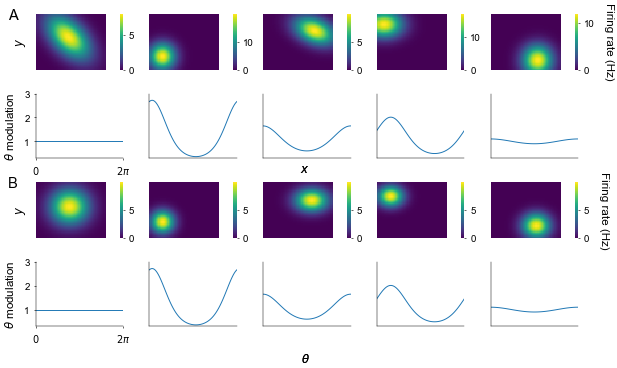

In [39]:
fig = plt.figure(figsize=(10, 6))
fig.text(-0.4, 0.9, 'A', transform=axes[0].transAxes, size=15)
fig.text(-0.4, 0.9, 'B', transform=axes[2*len(unit_used)].transAxes, size=15)


# Gaussian fields IPP ground truth
tmu = np.array([[250., 250.], [100., 100.], [400., 300.], [50., 350.], [360., 70.]])*1e-3
tprec = np.array([[0.0001, 0.0001, 0.00005], [0.0002, 0.0002, 0.0], [0.0001, 0.0002, 0.00005], 
                 [0.0001, 0.0002, 0.0], [0.00015, 0.00015, 0.0]])*1e6
trate_0 = np.array([8.0, 20.0, 10.0, 17.0, 12.0]) # Hz
tt_p = np.array([[0.0, 0.0], [1.0, 0.2], [0.5, 0.0], [0.7, 1.0], [0.1, 0.0]]) # beta, phi_0 for theta modulation

gauss_rate = mdl.parametrics.Gauss_GLM(trate_0.shape[0], 'exp')
gauss_rate.set_params(sample_bin, mdl.parametrics.gaussian_to_w(tmu, tprec, trate_0, tt_p)[:, :6])

grid_size = [int(arena_width/10), int(arena_height/10)]
grid_shape = [[left_x, right_x], [bottom_y, top_y]]


# ground truth
widths = [1, 1]
heights = [1, 1, 1, 1, 1]
nrows = 5
ncols = 2
spec = fig.add_gridspec(ncols=ncols, nrows=nrows, width_ratios=widths,
                         height_ratios=heights, left=0., right=0.2, bottom=0., top=1.)



for neuron in show_neurons:
    
    def func(pos):
        prevshape = pos.shape[1:]
        x = pos[0].flatten()
        y = pos[1].flatten()
        theta = (tt_p[neuron, 1]+0.5*np.pi)*np.ones(len(x)) # plot at unit modulation
        covariates = [x, y, theta]
        return gauss_rate.eval_rate(covariates, [neuron])[0].reshape(*prevshape)

    if neuron == 4:
        #cbar= True
        ticktitle='Firing rate (Hz)'
    else:
        #cbar = False
        ticktitle=''
        
    _, field = tools.compute_mesh(grid_size, grid_shape, func)
    _, ax = tools.visualize_field(field, grid_shape, ticktitle=ticktitle, figax=(fig, axes[neuron]))
    if neuron == 0:
        ylabel=r'$y$'
    else:
        ylabel=None
    tools.decorate_ax(ax, ylabel=ylabel, xlim=[left_x, right_x], ylim=[bottom_y, top_y],
                      spines=[False, False, False, False])






plt.savefig('output/cond_pop.svg')
plt.savefig('output/cond_pop.pdf')
plt.show()

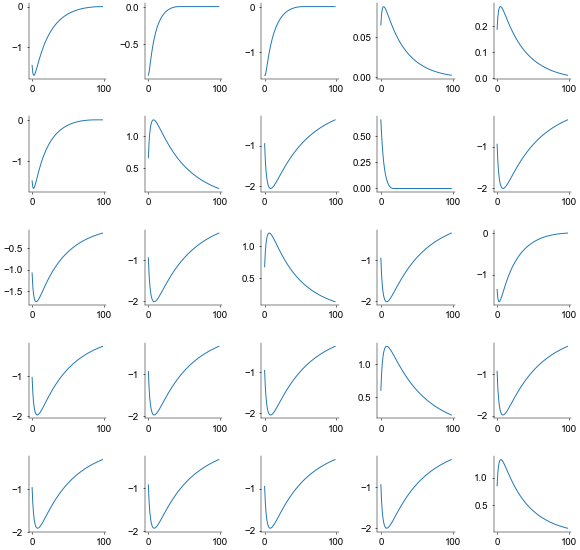

In [53]:
fig = plt.figure(figsize=(10, 10))
nrows = units
ncols = units
axes = [ fig.add_subplot(nrows, ncols, r * ncols + c + 1) for r in range(0, nrows) for c in range(0, ncols) ]

a = hist_couple().data.cpu().numpy()

for k in range(nrows):
    for l in range(ncols):
        axes[k*ncols + l].plot(a[k, l, ::-1])

fig.subplots_adjust(hspace=0.5, wspace=0.5)
plt.show()

In [54]:
# coupling matrix magnitude
A = a.data.cpu().numpy().mean(-1)

white = '#ffffff'
black = '#000000'
red = '#ff0000'
blue = '#0000ff'
weight_map = tools.make_cmap([blue, white, red], 'weight_map')


fig, ax, im = tools.draw_2d(A, origin='lower', cmap=weight_map, vmin=A.min(), vmax=A.max())
tools.decorate_ax(ax, spines=[False, False, False, False])
tools.add_colorbar(im, fig, ax, cbar_size='5%', ticktitle='coupling strength')

AttributeError: 'memoryview' object has no attribute 'cpu'

In [ ]:
# compute Hessian
glm.preprocess(rbehav_t, rc_t, batch_size=100000)#samples)
H = tools.hessian(glm.nll(0), glm.w_h).data.cpu().numpy()
ss = H.shape[0]*H.shape[1]
H = H.reshape(ss, ss)
w, v = np.linalg.eigh(H)
W.append(w)
V.append(v)

In [9]:
# sample spike raster
T = 5000
trials = 2
ini_train = rc_t[None, :, :glm.h_len-1].repeat(trials, axis=0)
cov = np.array(rbehav_t)[:, :T]
tr = glm.sample(list(cov), ini_train)

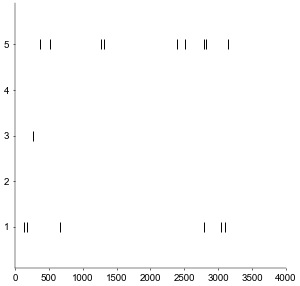

In [10]:
trial = 0
tools.raster_plot((5, 5), tr[trial], 5000, sample_bin*1000, units_used, markersize=100)
plt.show()

In [31]:
# GP fit and compare lengthscales
num_induc = 30
inducing_points = np.array([left_x + arena_width*np.random.rand(num_induc), \
                            bottom_y + arena_height*np.random.rand(num_induc)]).T[None, ...].repeat(units_used, axis=0)

l = np.ones(units_used)
v = np.ones(units_used)


kt = [('RBF', 'euclid', np.array([l, l]), v)]

glm_rate = mdl.nonparametrics.GP_covariates(units_used, inducing_points, kt, ([None],)*2, ([None],)*2, 
                                            inv_link='exp', shared_kernel_params=False, 
                                            jitter=1e-4, mean_ini=np.zeros((1, units_used, 1)))
glm_rate.set_params(sample_bin)

likelihood = mdl.likelihoods.Poisson(units_used, 'exp')
likelihood.set_params(sample_bin)

# NLL model
hist_len = 99 # 100 steps of spiketrain, no instantaneous element
hist_couple = mdl.filters.GP_filter(units_used, units_used, hist_len, sample_bin)

glm = mdl.inference.nll_optimized([glm_rate], likelihood, spk_couple=hist_couple)
glm.preprocess([r for r in rbehav_t[:2]], resamples, rc_t, batch_size=10000)
glm.to(dev)


# fit
sch = lambda o: optim.lr_scheduler.MultiplicativeLR(o, lambda e: 0.9)
opt_tuple = (optim.Adam, 100, sch)
opt_lr_dict = {'default': 1e-2}
glm.set_optimizers(opt_tuple, opt_lr_dict)

annealing = lambda x: min(1.0, 0.005*x)
losses = glm.fit(1000, margin=1e0, anneal_func=annealing)

plt.figure()
plt.plot(losses)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

RuntimeError: Sizes of tensors must match except in dimension 0. Got 25 and 5 (The offending index is 0)

In [ ]:
# show fits
grid_size = [int(arena_width/10), int(arena_height/10)]
grid_shape = [[left_x, right_x], [bottom_y, top_y]]

fig = plt.figure(figsize=(14, 4))
nrows = 2
ncols = 5
axes = [ fig.add_subplot(nrows, ncols, r * ncols + c + 1) for r in range(0, nrows) for c in range(0, ncols) ]

for n in range(units_used):
    def func(pos):
        prevshape = pos.shape[1:]
        x = pos[0].flatten()
        y = pos[1].flatten()
        #theta = np.zeros(len(x))
        covariates = np.array([x, y])#, theta)
        return glm_rate.eval_rate(covariates, [n])[0].reshape(*prevshape)

    _, field = tools.compute_mesh(grid_size, grid_shape, func)
    _, ax = tools.visualize_field(field, grid_shape, figax=(fig, axes[n]))

    #l_x = glm_rate.kernel_.lengthscale[0].item()
    #l_y = glm_rate.kernel_.lengthscale[1].item()
    l_x = glm_rate.kernel.lengthscale[n, 0].item()
    l_y = glm_rate.kernel.lengthscale[n, 1].item()
    ax.text(10.0, 10.0, r'$l_{x}=$'+'${:.1f}$ mm'.format(l_x), color='w', fontsize=14)
    ax.text(10.0, 50.0, r'$l_{y}=$'+'${:.1f}$ mm'.format(l_y), color='w', fontsize=14)

fig.subplots_adjust(wspace=0.3)
    
#plt.savefig('output/gp_lengthscales.svg')
#plt.savefig('output/gp_lengthscales.pdf')
plt.show()

In [ ]:
fig = plt.figure(figsize=(10, 10))
nrows = units_used
ncols = units_used
axes = [ fig.add_subplot(nrows, ncols, r * ncols + c + 1) for r in range(0, nrows) for c in range(0, ncols) ]

a = glm.raised_cosine_bumps(glm.a, glm.c, glm.w_h, glm.phi_h, glm.h_len-1)

for k in range(nrows):
    for l in range(ncols):
        axes[k*ncols + l].plot(a.data[k,l].cpu().numpy()[::-1])

fig.subplots_adjust(hspace=0.5, wspace=0.5)
plt.show()

#a = glm.raised_cosine_bumps(glm.a, glm.c, glm.w_u, glm.phi_u, glm.h_len)
#plt.plot(a.data[0,0].cpu().numpy())
#plt.show()

In [ ]:
# coupling matrix magnitude
A = a.data.cpu().numpy().mean(-1)

white = '#ffffff'
black = '#000000'
red = '#ff0000'
blue = '#0000ff'
weight_map = tools.make_cmap([blue, white, red], 'weight_map')


fig, ax, im = tools.draw_2d(A, origin='lower', cmap=weight_map, vmin=A.min(), vmax=A.max())
tools.decorate_ax(ax, spines=[False, False, False, False])
tools.add_colorbar(im, fig, ax, cbar_size='5%', ticktitle='coupling strength')

In [ ]:
# compute Hessian
glm.preprocess(rbehav_t, rc_t, batch_size=100000)#samples)
H = tools.hessian(glm.nll(0), glm.w_h).data.cpu().numpy()
ss = H.shape[0]*H.shape[1]
H = H.reshape(ss, ss)
w, v = np.linalg.eigh(H)
W.append(w)
V.append(v)

In [ ]:
trial = 0
tools.raster_plot((5, 5), tr[trial], 5000, sample_bin*1000, units_used, markersize=100)
plt.show()